# Analísis del Grupo A
#### Alkemy OT190-PYTHON
##### Tomás Martínez

### Script Setup

In [3]:
import xml.etree.ElementTree as ET
import datetime
import pandas as pd
import math
import operator
import os
import re
import seaborn as sns
import numpy as np
from typing import Counter
from functools import reduce
from multiprocessing import Pool

import time

#Locations
PATH_DATASET = os.path.join(os.getcwd(), 'dataset', 'Stack Overflow 11-2010', '112010 Meta Stack Overflow', 'posts.xml')
PATH_OUTPUT  = os.path.join(os.getcwd(), 'output')

#Load XML dataset
tree = ET.parse(PATH_DATASET)
root = tree.getroot()

#Helpers
def chunkify(iterable,len_of_chunk):
    for i in range(0,len(iterable), len_of_chunk):
        yield iterable[i:i + len_of_chunk]
def flatten(dato):
    return reduce(operator.concat, dato, [])
def striphtml(data):
    p = re.compile(r'<.*?>')
    return p.sub('', data)

## Top 10 tags con mayores respuestas aceptadas

### Map Functions and mapper

In [4]:
def obtener_tags_raw(chunk):#Map
    if 'AcceptedAnswerId' in chunk.attrib:
        tags = chunk.attrib.get("Tags")
        return tags
        
def transformar_en_lista(dato):#Map
    return dato.replace('><' , ' ').lstrip('<').rstrip('>').split()

def mapper(root_chunks):#Mapper
    mapped = list(map(obtener_tags_raw, root_chunks))
    mapped = list(filter(None, mapped))
    mapped = list(map(transformar_en_lista, mapped))   
    mapped = list(flatten(mapped))   
    return dict(Counter(mapped))

### Funciones reduce y reducer

In [5]:
def reducir_dict_palabra_cantidad(dict_1, dict_2):#Reduce
    get_set = set(dict_1)|set(dict_2)
    for key in get_set:
        dict_2.update( {key : dict_1.get(key,0) + dict_2.get(key,0)} )
    return dict_2

def reducer(data_chunks):#Reducer
    reduced = reduce(reducir_dict_palabra_cantidad, data_chunks)
    return reduced

### Map Reduce - Código y explicación

In [6]:
root_chunks = chunkify(root, 100)
mapped = list(map(mapper, root_chunks))
reduced = reducer(mapped)

En primer lugar la variable ```root_chunks``` contiene una lista con el dataset partido entre 100 partes iguales con ```chunkify()```

Luego la función ```mapper()``` se mapea a cada chunk, subsecuentemente dentro de la función mapper hay maps que aplicarán al contenido de cada chunk, uno de estos maps, ```obtener_tags_raw()``` es un filtro que trae solo tags de las respuestas aceptadas, el resto de los maps se encargan del formato concluyendo así el [shuffle](https://data-flair.training/blogs/shuffling-and-sorting-in-hadoop/#:~:text=Shuffle%20phase%20in%20Hadoop%20transfers,associated%20with%20the%20same%20key.)

Por último  ```reducer()``` se le aplicará a nuestros chunks ya mapeados para subsecuentemente aplicar la función ```reducir_dict_palabra_cantidad()``` que reduce el contenido de cada chunk dejando las sumatorias de los puntos de cada tag en la variable ```reduced```


### Volcado a archivo .csv

In [7]:
df = pd.DataFrame(Counter(reduced).most_common(10), columns=['Tag', 'AcceptedAnswer'])
df.to_csv(f'{PATH_OUTPUT}/Grupo_A-top_10_tags_rtas_aceptadas.csv', index=False)
df = pd.read_csv(f'{PATH_OUTPUT}/Grupo_A-top_10_tags_rtas_aceptadas.csv', header=0, names=["Tag", "AcceptedAnswers"])
df

,Tag,AcceptedAnswers
0,discussion,2875
1,feature-request,1775
2,support,1723
3,bug,1252
4,status-completed,1189
5,stackoverflow,679
6,reputation,518
7,tags,449
8,questions,408
9,status-bydesign,382


## Relación entre cantidad de palabras en un post y su puntaje

### Mapper

In [8]:
def obtener_palabraspost_postscore(chunk):#Map
    if chunk.attrib.get("PostTypeId") == '1':
        post_score = chunk.attrib.get("Score")
        post_body = striphtml(chunk.attrib.get("Body"))
        body_words = Counter(post_body.split())
        count_body_words = len(body_words)
        if count_body_words:
            return {int(count_body_words) : int(post_score)}

def mapper(root_chunks):
    mapped = list(map(obtener_palabraspost_postscore, root_chunks))
    mapped = list(filter(None, mapped))
    return mapped

### Reduce

In [9]:
def reductor(data1, data2):
    for key, value2 in data2.items():
        if key in data1.keys():
            data1.update({key: int(math.ceil((data1[key]+value2)/2))})
        else:
            data1.update({key: value2})
    return data1

In [10]:
root_chunks = chunkify(root, 100)
mapped = list(map(mapper, root_chunks))
mapped = list(flatten(mapped))
reduced = reduce(reductor, mapped)

df = pd.DataFrame(reduced.items(), columns=['WordsPerPost', 'Score'])

### Volcado a archivo csv

In [11]:
df.to_csv(f'{PATH_OUTPUT}/Grupo_A-relacion_palabras_por_post_puntaje.csv', index=False)
df = pd.read_csv(f'{PATH_OUTPUT}/Grupo_A-relacion_palabras_por_post_puntaje.csv', header=0, names=["WordsPerPost", "Score"])
df.sort_values(by=['WordsPerPost'], ascending=False)

,WordsPerPost,Score
337,1274,37
241,993,16
353,716,3
323,711,2
299,681,-6
...,...,...
124,5,3
181,4,3
286,3,3
330,2,3


### Scatterplot
En este scatterplot podemos ver cómo en promedio la mayoría de los upvotes fueron a los posts con menos de 450 palabras

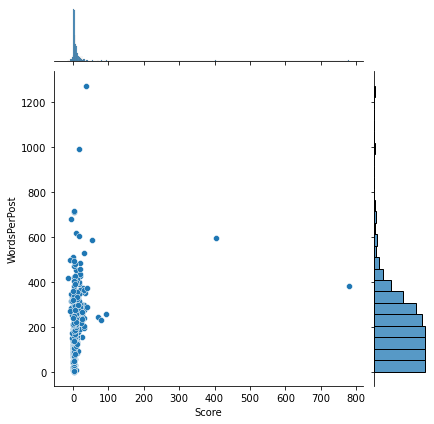

In [12]:
df.dropna(inplace=False)
sns.jointplot(x = "Score", y = "WordsPerPost", data = df)

## Demora de respuesta promedio en posts

### Mapper

In [9]:
# def obtener_dict_postid_fechacreate(chunk):#Map
#     if '1' in chunk.attrib.get("PostTypeId"):        
#         post_id = chunk.attrib.get("Id")        
#         fecha_creac_orig = chunk.attrib.get("CreationDate")
#         fecha_creac_orig = fecha_creac_orig.replace('T', ' ').split('.')[0]
#         dt_fecha_creac_orig = datetime.datetime.strptime(fecha_creac_orig, '%Y-%m-%d %H:%M:%S')
#         unix_time = datetime.datetime.timestamp(dt_fecha_creac_orig)
#         return {post_id : unix_time}


# def mapper(root_chunks):
#     mapped_1 = list(map(obtener_dict_postid_fechacreate, root_chunks))
#     mapped_1 = list(filter(None, mapped_1))
#     return mapped

In [ ]:
# root_chunks = chunkify(root, 100)
# mapped = list(map(mapper, root_chunks))